# Prepare the training database

In [1]:
import Bio.SeqIO as SeqIO

LTR_sequences = [record for record in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/sampled_from_clusters.fasta", "fasta")]

non_LTR_sequences = []

### Create a sampling distribution from sequence lengths

Text(0.5, 0, 'Sequence Length')

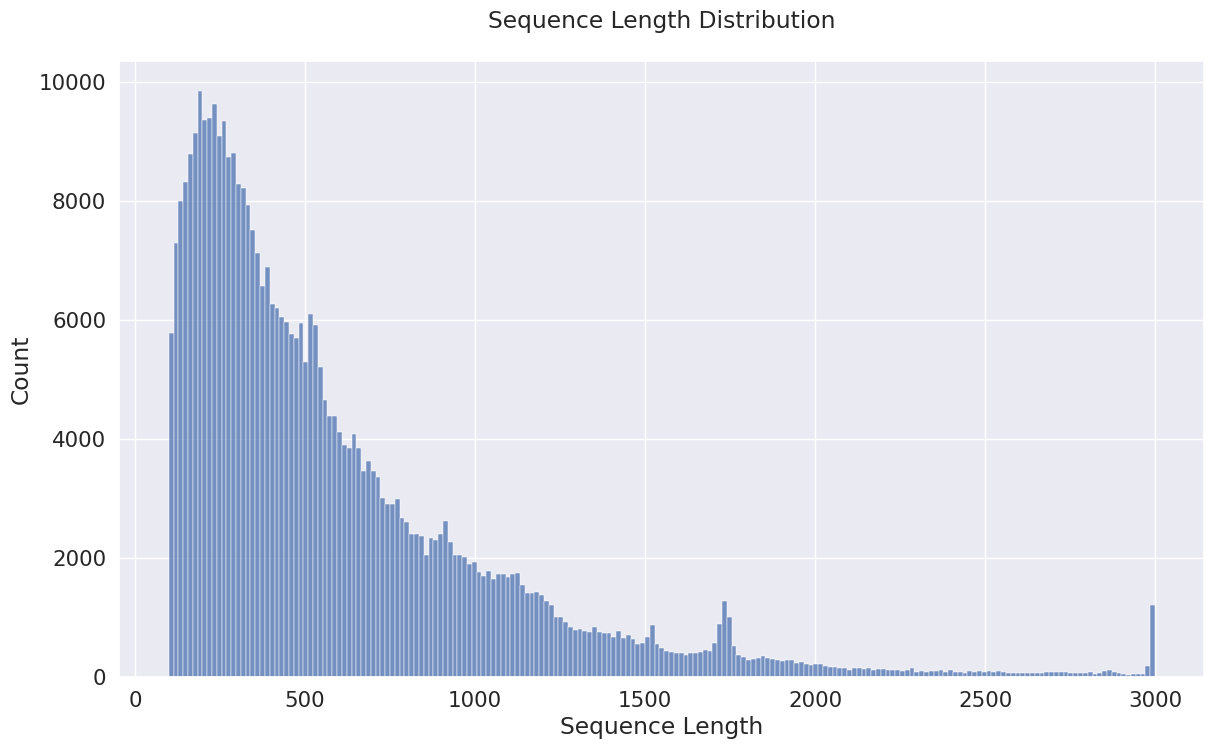

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
seq_lens = [len(rec.seq) for rec in LTR_sequences ]#if len(rec.seq) <= 2000]
sns.set(rc={'figure.figsize':(14,8)}, font_scale=1.4)

sns.histplot(seq_lens)
plt.title("Sequence Length Distribution",pad=24)
plt.ylabel("Count")
plt.xlabel("Sequence Length")

### Generate random sequences
- let 25 % of the negative sequences be generated sequences

In [3]:
import random
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import random 
sequence_id = 0 
n_seqs = int(len(LTR_sequences) * 0.25)
avg_len = int(sum([len(seq) for seq in LTR_sequences])/len(LTR_sequences))

for _ in range(n_seqs):
    length = random.choice(seq_lens)
    sequence = ''.join([random.choice(["A","C", "T", "G"]) for _ in range(length)])
    record = SeqRecord(
        Seq(sequence),
        id=f"{sequence_id}_non-LTR_generated",
        description="randomly generated non-LTR sequence")
    sequence_id += 1

    non_LTR_sequences.append(record)

Text(0.5, 0, 'Sequence Length')

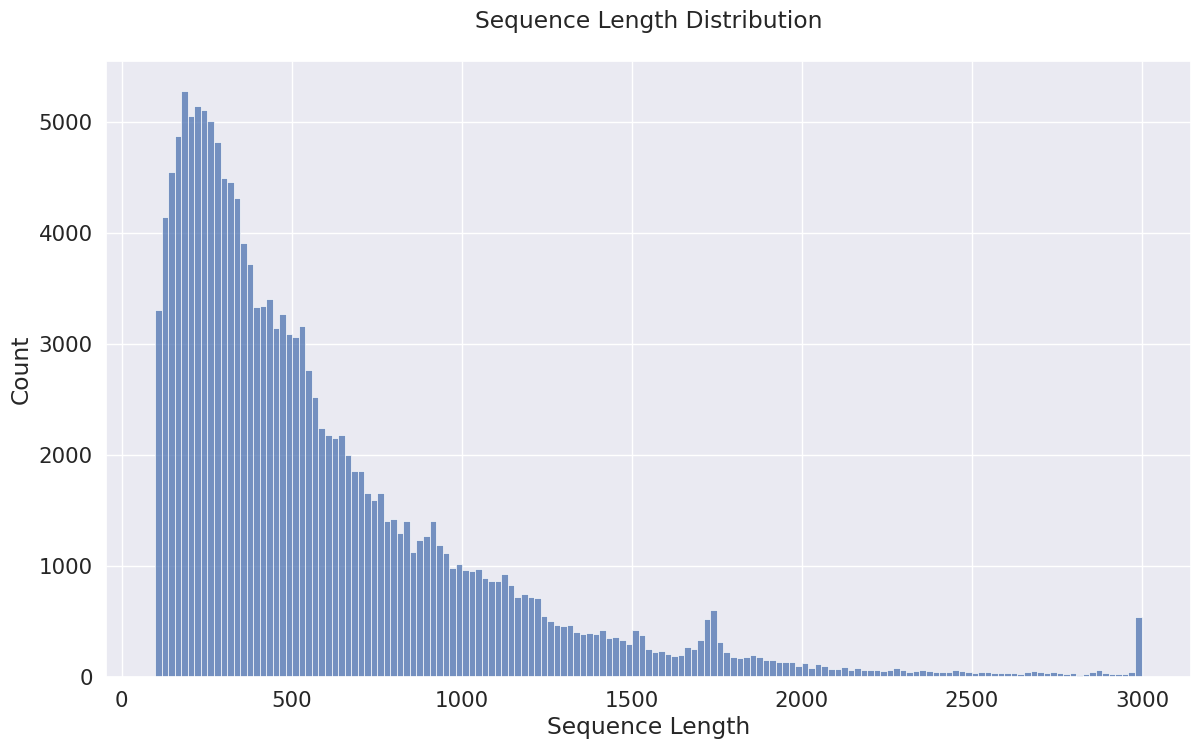

In [4]:
seq_lens = [len(rec.seq) for rec in non_LTR_sequences]
sns.set(rc={'figure.figsize':(14,8)}, font_scale=1.4)

sns.histplot(seq_lens)
plt.title("Sequence Length Distribution",pad=24)
plt.ylabel("Count")
plt.xlabel("Sequence Length")

### Take sequences cut out from genomic sequences 
- Identify the distribution of species within the positive DB
- Extract percentually the same amount of sequences from each species as is represented in the positive DB

In [10]:
from os import listdir
from os.path import isfile, join
import name_transform_utils as nt
genomes_path = "/mnt/extra/genomes/"
genomes_path2 = "/opt/genomes/"
annotation_path = "/opt/xhorvat9_TE_DBs/Genomes/Genomes/all_annotations/"
genome_files = [genomes_path + f for f in listdir(genomes_path) if isfile(join(genomes_path, f))] + [genomes_path2 + f for f in listdir(genomes_path2) if isfile(join(genomes_path2, f))]
annotation_files = [f for f in listdir(annotation_path) if isfile(join(annotation_path, f))]

# load in the "fasta_file"-"annotation_file" pairs dictionary
annot_dict = nt.assign_annotation_file(genome_files, annotation_files)

In [22]:
pd.DataFrame({"vals":list(annot_dict.values())})["vals"].astype(str).value_counts().sort_values()

/mnt/extra/genomes/Pogostemon_cablin.fasta.gz                        1
/opt/genomes/Cmoschata_genome_v1.fa.gz                               1
/opt/genomes/Lemna_minor_vs1.fa.gz                                   1
/opt/genomes/Malania_oleifera_genome.fa.gz                           1
/mnt/extra/genomes/Citrus_clementina_v1.0.genome.fa.gz               1
                                                                  ... 
/mnt/extra/genomes/Ipomoea_triloba_chr_v3.fa.gz                      1
/opt/genomes/S_lycopersicum_chromosomes.4.00.fa.gz                   1
/opt/genomes/Calamus_simplicifolius.WGS.fasta.gz                     1
/mnt/extra/genomes/Prunus_avium_v1.0.a1_pseudomolecule.fasta.gz      1
None                                                               206
Name: vals, Length: 95, dtype: int64

#### Identify LTR locations

In [ ]:
import tqdm
import pandas as pd
LTRs = {}
for species in annot_dict:
    annot = pd.read_csv(f"{annotation_path}{species}.txt", sep="\t", low_memory=False).iloc[:-1,]
    LTR_IDs = set(annot["LTR_ID"])
    
    print(f"Processing {species}")
    LTRs[species] = {}
    for idx in tqdm.tqdm(LTR_IDs):
        element = annot[annot["LTR_ID"] == idx]
        element_5LTR = element[element["Domain"] == "intact_5ltr"][["Start", "End"]]
        element_3LTR = element[element["Domain"] == "intact_3ltr"][["Start", "End"]]
        # info = element[element["Domain"] == "intact_5ltr"][[ "Superfamily", "Lineages", "Divergence", "Chromosome"]]
        try:
            LTRs[species][idx] = ({"Start": int(element_5LTR["Start"].iloc[0]),"End": int(element_5LTR["End"].iloc[0])},{"Start": int(element_3LTR["Start"].iloc[0]),"End": int(element_3LTR["End"].iloc[0])})
        except:
            pass

In [ ]:
import json

with open('LTR_locations_extra.txt', 'w') as convert_file:
     convert_file.write(json.dumps(LTRs))

In [5]:
import json

with open('LTR_locations_extra.txt', 'r') as convert_file:
     LTRs = json.load(convert_file)

### Identify the sequence content from each species

In [5]:
import Bio.SeqIO as SeqIO
chromosome_sequences = {(rec.id): rec.seq for rec in SeqIO.parse("/opt/xhorvat9_TE_DBs/Genomes/Genomes/Zea_mays.fa", "fasta")}

In [31]:
def check_interval(LTRs, chromosome, start, end):
    ltr_starts = LTRs[LTRs["Chromosome"].str.match(chromosome)].Start
    ltr_ends = LTRs[LTRs["Chromosome"].str.match(chromosome)].End
    ii = pd.IntervalIndex.from_arrays(ltr_starts, ltr_ends, closed="both")
    return ii.contains(start) | ii.contains(end)

In [32]:
sequence_dicts = dict([(genome, dict([(record.id, record.seq) for record in SeqIO.parse(f"{genomes_path}{genome}.fa", "fasta")])) for genome in genomes])

In [33]:
LTRs = {}
for genome in genomes:
    annot = pd.read_csv(f"{annotation_path}{genome}.txt", sep="\t", low_memory=False)
    LTRs[genome] = annot[annot["Domain"].str.contains("ltr")]

#### Extract the sequences avoiding the LTR locations and regions with N count above 10%

In [34]:
import random
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
n_sequences = int(len(LTR_sequences) * 0.75)

for i in range(n_sequences):
    # Randomly sample genome
    chosen_genome = random.choice(genomes)
    # randomly sample chromosome
    chosen_chromosome = random.choice(list(sequence_dicts[chosen_genome].keys()))
    # randomly sample length
    chosen_length = random.choice(seq_lens)
    if len(sequence_dicts[chosen_genome][chosen_chromosome])-chosen_length < 50:
        i -= 1
        continue
    random_start = random.randint(0, len(sequence_dicts[chosen_genome][chosen_chromosome])-chosen_length)
    while any(check_interval(LTRs[chosen_genome], chosen_chromosome, random_start, random_start+chosen_length)):
        random_start = random.randint(0, len(sequence_dicts[chosen_genome][chosen_chromosome])-chosen_length)
    seq = sequence_dicts[chosen_genome][chosen_chromosome][random_start:random_start+chosen_length]
    if seq.count("N") > len(seq)/10:
        i -= 1
        continue
    record = SeqRecord(
        Seq(seq),
        id=f"{sequence_id}_non-LTR_genome_extract",
        description=f"{chosen_genome} chr{chosen_chromosome} {random_start}:{random_start+chosen_length}")
    sequence_id += 1
    non_LTR_sequences.append(record)

In [ ]:
SeqIO.write(non_LTR_sequences, "non_LTR_sequences.fasta", "fasta")